# **Task No 2 (Part a)**     
##  Submitted by ***Aqsa Abu Bakar(400517)***

---



For sentiment analysis you are required to use the sarcasm news dataset. (given n input from the dataset/random input your code should tell if there is sarcasm in it or not.) (two portions in test file. 1 for performance metrics on running on test_set and one for random input from the user to detect sarcasm.) https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

## **Connecting to Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## **Importing Libraries**

In [ ]:
import numpy as np
import requests
import tensorflow as tf
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.utils import plot_model
import graphviz
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import pickle
from nltk.tokenize import word_tokenize
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## **Loading the Dataset**

In [ ]:
def load_json_file(file_path):
    response = requests.get(file_path)
    data = json.loads(response.text)
    return data
# Load JSON data from the URL
data = load_json_file('https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json')

## **Visualizing the dataset**

### **Wordcloud**
Word clouds are a useful technique in sentiment analysis for several reasons. They provide a quick overview of frequently occurring words, enabling analysts to identify prevalent sentiments or topics. Word clouds highlight key terms by highlighting them with larger font sizes, providing insights into word associations. They also help in focusing on contextual understanding by displaying words in proximity to one another.

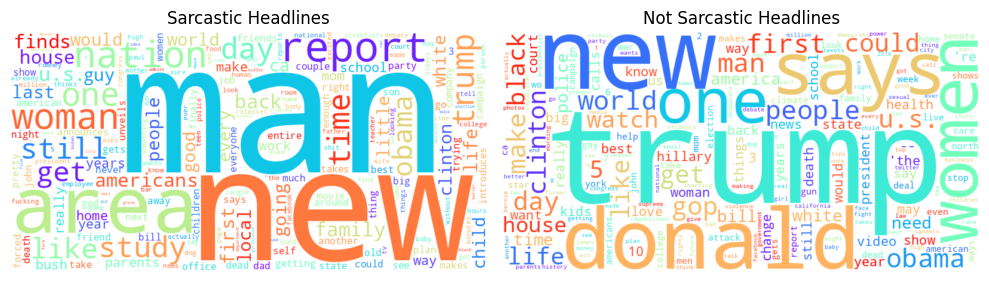

In [ ]:
data_visualize = pd.read_json('https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json')
# Define a function to remove stop words, specified characters, and contractions
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    # Add additional characters to exclude
    exclude_chars = set(string.punctuation)
    # Define contractions to exclude
    contractions = ["'s", "n't"]
    word_tokens = word_tokenize(text)
    # Remove stop words, specified characters, and contractions
    filtered_text = [word for word in word_tokens if (word.lower() not in stop_words)
                     and (word not in exclude_chars)
                     and (word.lower() not in contractions)]
    return ' '.join(filtered_text)
# Apply the function to the headlines
data_visualize['clean_headline'] = data_visualize['headline'].apply(clean_text)
# Create word frequency counters for sarcastic and not sarcastic headlines
sarcastic_counter = Counter(' '.join(data_visualize[data_visualize['is_sarcastic'] == 1]['clean_headline']).split())
not_sarcastic_counter = Counter(' '.join(data_visualize[data_visualize['is_sarcastic'] == 0]['clean_headline']).split())
## Combine counters and sort by frequency
combined_counter = sarcastic_counter + not_sarcastic_counter
sorted_words = sorted(combined_counter.items(), key=lambda kv: kv[1], reverse=True)
# Create word frequency charts
plt.figure(figsize=(10, 5))
# Create a wordcloud for sarcastic headlines
sarcastic_wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white', colormap='rainbow').generate_from_frequencies(sarcastic_counter)
plt.subplot(121)
plt.imshow(sarcastic_wordcloud, interpolation='bilinear')
plt.title('Sarcastic Headlines')
plt.axis('off')
# Create a wordcloud for not sarcastic headlines
not_sarcastic_wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white', colormap='rainbow').generate_from_frequencies(not_sarcastic_counter)
plt.subplot(122)
plt.imshow(not_sarcastic_wordcloud, interpolation='bilinear')
plt.title('Not Sarcastic Headlines')
plt.axis('off')
plt.tight_layout()
plt.show()

### **Top 10 Most occured words**
The frequency distribution of the top 10 words can be used to identify common sentiments, extract key indicators, and improve the accuracy and efficiency of sentiment analysis models.

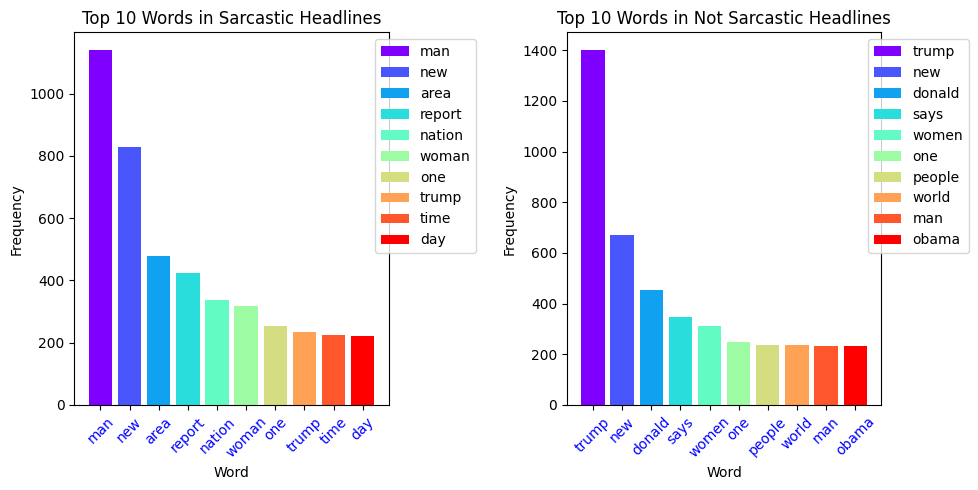

In [ ]:
# Get top 10 words from each counter
top_10_sarcastic = sarcastic_counter.most_common(10)
top_10_not_sarcastic = not_sarcastic_counter.most_common(10)
# Plot word frequency distribution
plt.figure(figsize=(10, 5))
plt.subplot(121)
colors = plt.cm.rainbow(np.linspace(0, 1, len(top_10_sarcastic)))
# Bar plot with rainbow colors
bars = plt.bar(range(len(top_10_sarcastic)), [x[1] for x in top_10_sarcastic], color=colors)
# Set x-axis labels and rotate them by 45 degrees
plt.xticks(range(len(top_10_sarcastic)), [x[0] for x in top_10_sarcastic], rotation=45, color='blue')
plt.title('Top 10 Words in Sarcastic Headlines')
plt.xlabel('Word')
plt.ylabel('Frequency')
# Add legend to the bars
plt.legend(bars, [x[0] for x in top_10_sarcastic], loc='upper right', bbox_to_anchor=(1.3, 1))
# Second subplot
plt.subplot(122)
colors = plt.cm.rainbow(np.linspace(0, 1, len(top_10_sarcastic)))
# Bar plot with rainbow colors
bars = plt.bar(range(len(top_10_not_sarcastic)), [x[1] for x in top_10_not_sarcastic], color=colors)
# Set x-axis labels and rotate them by 45 degrees
plt.xticks(range(len(top_10_not_sarcastic)), [x[0] for x in top_10_not_sarcastic], rotation=45, color='blue')
plt.title('Top 10 Words in Not Sarcastic Headlines')
plt.xlabel('Word')
plt.ylabel('Frequency')
# Add legend to the bars
plt.legend(bars, [x[0] for x in top_10_not_sarcastic], loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()

## **Visualizing the distribution of both classes in the dataset**

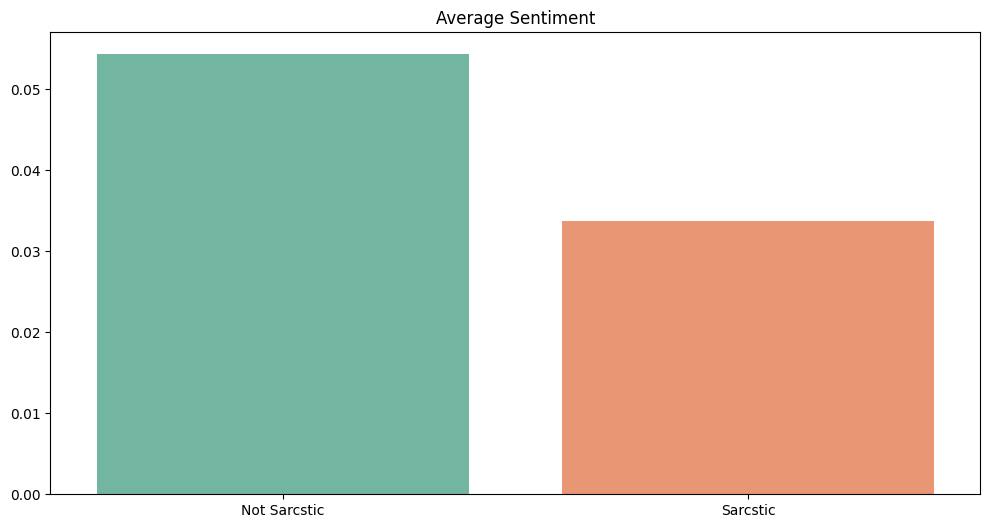

In [ ]:
def sentiment_and_word_count(headline):
    blob = TextBlob(headline)
    sentiment = blob.sentiment.polarity
    word_count = len(blob.words)
    return sentiment, word_count

data = load_json_file('https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json')

headlines = [entry['headline'] for entry in data]
labels = [entry['is_sarcastic'] for entry in data]

labels = np.array(labels)

sentiments = []
word_counts = []

for headline in headlines:
    sentiment, word_count = sentiment_and_word_count(headline)
    sentiments.append(sentiment)
    word_counts.append(word_count)

average_sentiments = []
colors = sns.color_palette("Set2")
for i in range(2):
    mask = labels == i
    sentiment_values = np.array(sentiments)[mask]
    average_sentiments.append(np.mean(sentiment_values))

plt.figure(figsize=(12, 6))
sns.barplot(x=['Not Sarcstic', 'Sarcstic'], y=average_sentiments,palette=colors)
plt.title('Average Sentiment')
plt.show()

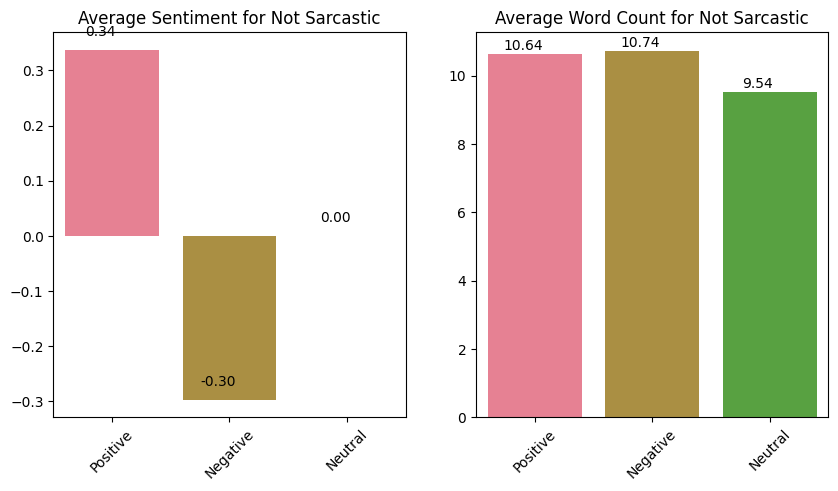

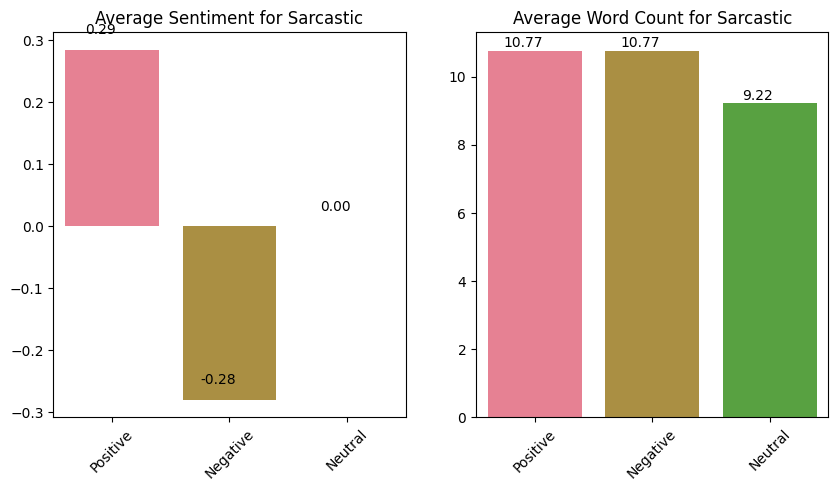

In [ ]:

def sentiment_and_word_count(headline):
    blob = TextBlob(headline)
    sentiment = blob.sentiment.polarity
    word_count = len(blob.words)
    return sentiment, word_count

def load_json_file(url):
    response = requests.get(url)
    data = json.loads(response.text)
    return data

data = load_json_file('https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json')

headlines = [entry['headline'] for entry in data]
labels = [entry['is_sarcastic'] for entry in data]

labels = np.array(labels)

sentiments = []
word_counts = []
word_categories = []

for headline in headlines:
    sentiment, word_count = sentiment_and_word_count(headline)
    sentiments.append(sentiment)
    word_counts.append(word_count)

    blob = TextBlob(headline)
    polarity = blob.sentiment.polarity

    if polarity > 0:
        word_categories.append('Positive')
    elif polarity < 0:
        word_categories.append('Negative')
    else:
        word_categories.append('Neutral')

for i in range(2):
    mask = labels == i
    sentiment_values = np.array(sentiments)[mask]
    word_count_values = np.array(word_counts)[mask]
    word_category_values = np.array(word_categories)[mask]

    average_sentiments = []
    word_count_categories = []

    for category in ['Positive', 'Negative', 'Neutral']:
        mask_category = word_category_values == category
        sentiment_values_category = sentiment_values[mask_category]
        word_count_values_category = word_count_values[mask_category]

        average_sentiments.append(np.mean(sentiment_values_category))
        word_count_categories.append(np.mean(word_count_values_category))

    # Plotting average sentiment
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    colors = sns.color_palette("husl")
    bars = sns.barplot(x=['Positive', 'Negative', 'Neutral'], y=average_sentiments, palette=colors)

    # Add values on top of each bar
    for bar, value in zip(bars.patches, average_sentiments):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom')

    # Set x-axis labels and rotate them by 45 degrees
    plt.xticks(rotation=45)

    plt.title(f'Average Sentiment for {"Sarcastic" if i == 1 else "Not Sarcastic"}')

    plt.subplot(122)

    colors = sns.color_palette("husl")
    bars = sns.barplot(x=['Positive', 'Negative', 'Neutral'], y=word_count_categories, palette=colors)

    # Add values on top of each bar
    for bar, value in zip(bars.patches, word_count_categories):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom')

    # Set x-axis labels and rotate them by 45 degrees
    plt.xticks(rotation=45)

    plt.title(f'Average Word Count for {"Sarcastic" if i == 1 else "Not Sarcastic"}')

    # No need to manually add legend, let Seaborn handle it
    plt.show()


## **Extracting headlines and labels**

In [ ]:
# Now you can work with the loaded JSON data
# For example, you can extract headlines and labels
headlines = [entry['headline'] for entry in data]
labels = [entry['is_sarcastic'] for entry in data]
headlines = [d['headline'] for d in data]
labels = [d['is_sarcastic'] for d in data]
# Convert labels to binary
labels = np.array(labels)

In [ ]:
headlines[0:5]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [ ]:
labels[0:5]

array([0, 0, 1, 1, 0])

## **Initialize the tokenize**
Tokenization, padding, sequencing, and training data are essential steps in sentiment analysis, converting textual data into a format for analysis and model training. These steps help train sentiment analysis models to identify patterns and relationships between words and sentiments.

**Tokenization:**

Tokenization involves breaking down the text into individual words or tokens.
It helps convert textual data into a format that can be used for analysis and model training.

**Padding:**

Padding ensures that all sequences (lists of tokens) have the same length.
Neural networks typically require input data of uniform length, so padding is used to add zeros or special tokens to shorter sequences.

**Sequence:**

Sequencing involves arranging the tokens in a specific order to capture the sequential nature of language.
This is crucial for tasks like sentiment analysis, where the order of words can impact the overall sentiment.

**Training Data:**

The training data is used to train a sentiment analysis model.
It consists of labeled examples where the sentiment (positive, negative, neutral) is associated with the corresponding text.
The model learns to identify patterns and relationships between words and sentiments during the training process.


In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(headlines)
#with open('/content/drive/My Drive/Aqsa Abu Bakar(DL-ProjectT2b)/Sentiment_tokenizer.pkl', 'wb') as handle:
    #pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## **Convert headlines to sequences**

In [ ]:
sequences = tokenizer.texts_to_sequences(headlines)

In [ ]:
sequences[0:5]

[[308, 1, 679, 3337, 2298, 48, 382, 2576, 1, 6, 2577, 1],
 [4, 1, 3338, 2746, 22, 2, 166, 1, 416, 3112, 6, 258, 9, 1002],
 [145, 838, 2, 907, 1749, 2093, 582, 4719, 221, 143, 39, 46, 2, 1],
 [1485, 36, 224, 400, 2, 1832, 29, 319, 22, 10, 2924, 1393, 1, 968],
 [767, 719, 4720, 908, 1, 623, 594, 5, 4, 95, 1309, 92]]

## **Pad sequences**

In [ ]:
max_len = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Save max_len to a file
#with open('/content/drive/My Drive/Aqsa Abu Bakar(DL-ProjectT2b)/max_len.pkl', 'wb') as max_len_file:
    #pickle.dump(max_len, max_len_file)


## **Assuming padded_sequences & labels are your features and labels**

x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

For Splitting the Dataset to test and validations set this code will be used

## **Split data into training and test sets**

In [ ]:
from sklearn.model_selection import train_test_split
X_temp, x_test, y_temp, y_test = train_test_split(padded_sequences, labels, test_size=0.15, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15/0.75, random_state=42)

## **Convert data to numpy arrays**

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## **The Architecture when used with Dropout abd regularization performs better**

The Architecture outperforms due to several factors. It uses a **dropout regularization** in the **LSTM layer**, preventing **overfitting** by randomly dropping out a fraction of neurons during each training step. This technique is more effective for **sequence-to-sequence models** like LSTM. The architecture also applies **recurrent dropout** to the LSTM layer, which discourages large weights by adding a penalty to the loss function. **L2 regularization** is applied to the **Dense layer's** weights, reducing the likelihood of large weights. The Architecture is **32 units** in the LSTM layer, the architecture uses them in both forward and backward directions, providing a more comprehensive understanding of sentence structure.

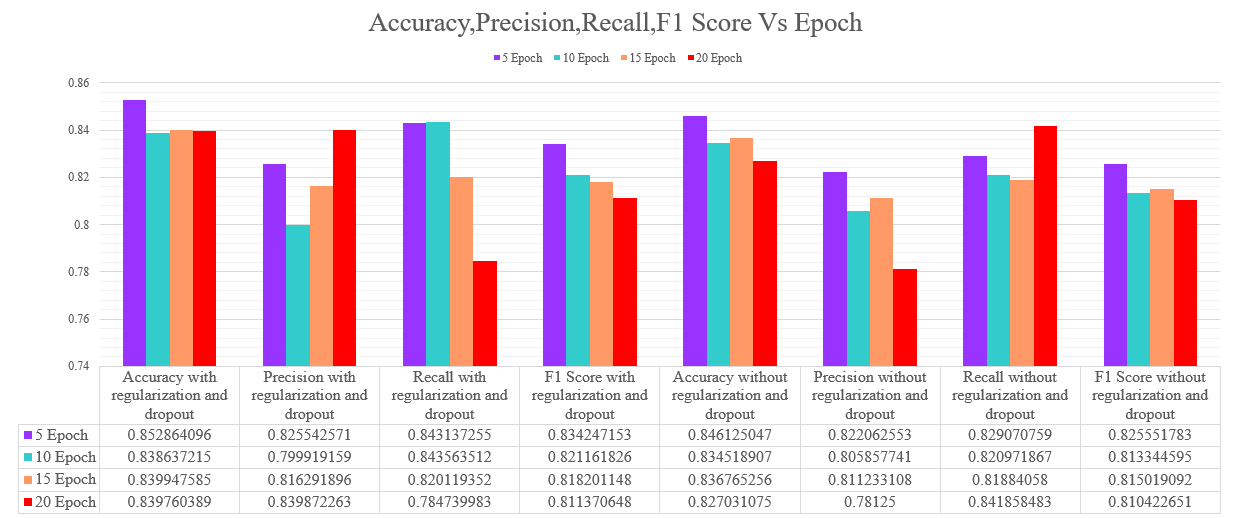

The graph shows the accuracy, precision, recall, and F1 scores of a machine learning model with and without regularization and dropout over 20 epochs. Regularization and dropout are techniques used to prevent overfitting, where a model memorizes training data too well and performs poorly on unseen data. The model with regularization and dropout generally has higher accuracy, precision, and recall scores than the model without regularization and dropout. The recall of the model with regularization and dropout is higher than that of the model without regularization and dropout. The F1 score of the model with regularization and dropout is also higher than that of the model without regularization and dropout.

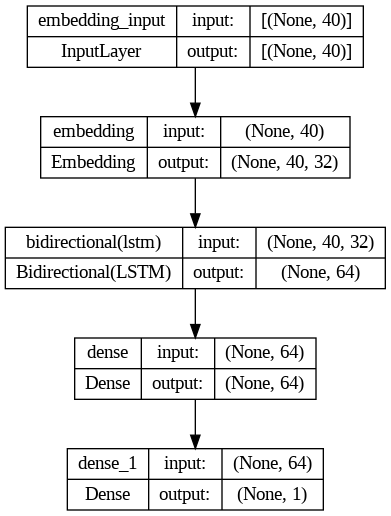

In [ ]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L2

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(5000, 32, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=L2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
#Display the model architecture in SVG format
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## **Training for how many Epochs?**
The graph displays the accuracy, precision, recall, and F1 scores of a machine learning model over 20 epochs.The model learns to make better predictions as it trains on more data, but no significant improvement occurs after 10 epochs.

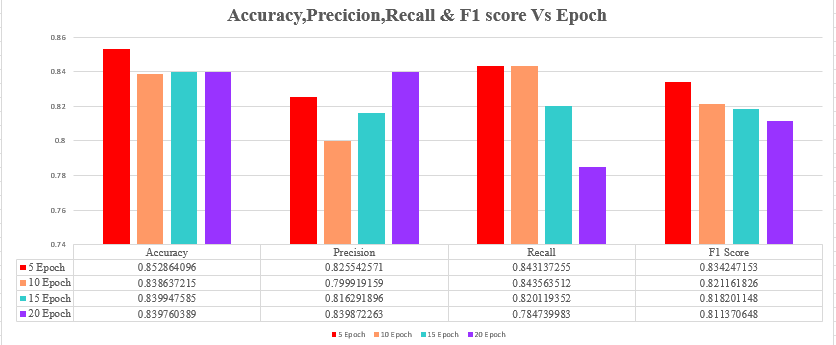

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
668/668 [==============================] - 216s 307ms/step - loss: 0.5063 - accuracy: 0.7976 - val_loss: 0.3492 - val_accuracy: 0.8527
Epoch 2/5
668/668 [==============================] - 191s 286ms/step - loss: 0.2893 - accuracy: 0.8840 - val_loss: 0.3401 - val_accuracy: 0.8574
Epoch 3/5
668/668 [==============================] - 183s 273ms/step - loss: 0.2368 - accuracy: 0.9092 - val_loss: 0.3572 - val_accuracy: 0.8519
Epoch 4/5
668/668 [==============================] - 194s 291ms/step - loss: 0.1989 - accuracy: 0.9284 - val_loss: 0.3908 - val_accuracy: 0.8516
Epoch 5/5
668/668 [==============================] - 187s 280ms/step - loss: 0.1683 - accuracy: 0.9404 - val_loss: 0.3942 - val_accuracy: 0.8512


**Even K fold training didn't helped much**

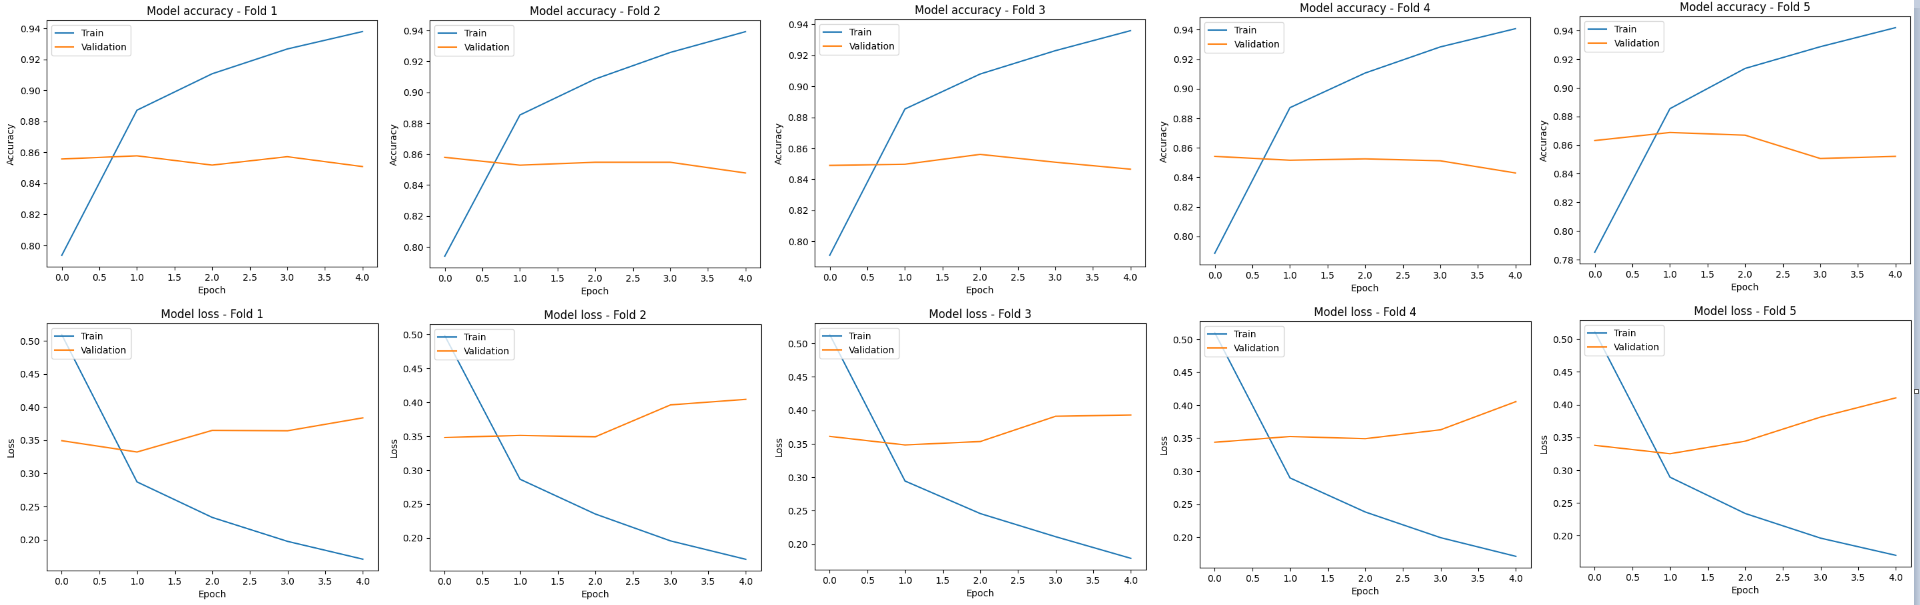

## **Plotting the Accuracy & Loss graphs**

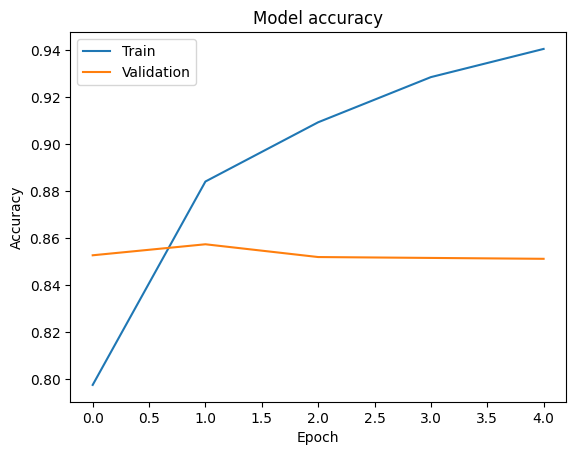

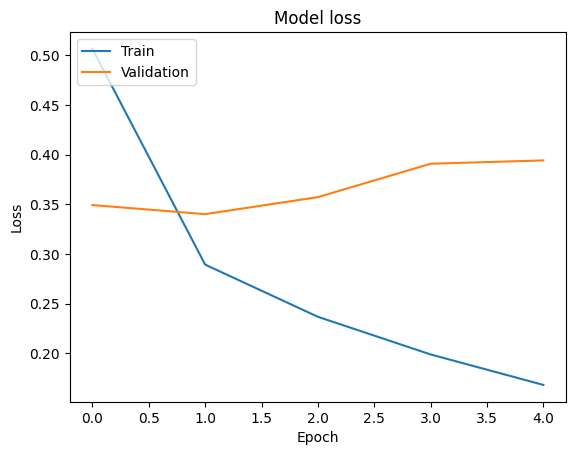

In [ ]:
import matplotlib.pyplot as plt# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Saving The Model**

In [ ]:
#model.save('/content/drive/My Drive/Aqsa Abu Bakar(DL-ProjectT2b)/sarcasm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **Loading the Model**

In [ ]:
# Load the saved model for testing
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/Aqsa Abu Bakar(DL-ProjectT2b)/sarcasm_model.h5')
# Evaluate performance metrics on the test set using the loaded model
y_pred = loaded_model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

167/167 [==============================] - 4s 24ms/step


## **Evaluating the model on Test Set**

In [ ]:
# Assuming 'model' is your trained model
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test loss: ", loss)
print("Test accuracy: ", accuracy)

Test loss:  0.39416152238845825
Test accuracy:  0.8511793613433838


## **Evaluation Metrics**

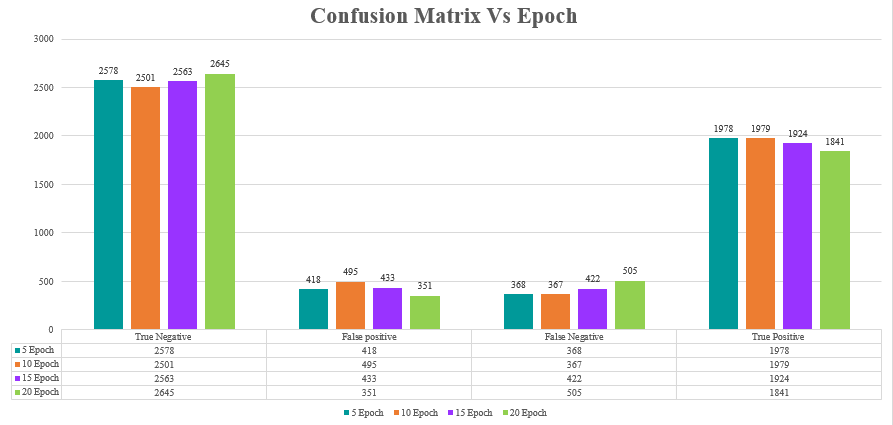

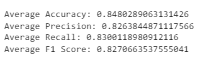

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.8511793335829277
Precision: 0.8235294117647058
Recall: 0.8414322250639387
F1 Score: 0.8323845667299178
Confusion Matrix:
[[2573  423]
 [ 372 1974]]


## **Visualizing the Confusion matrix**

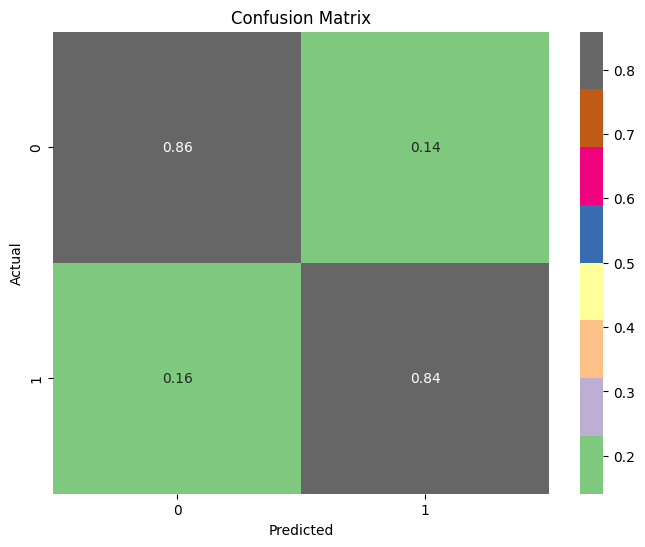

In [ ]:
# Assuming that y_test and y_pred are already defined
y_test = y_test
y_pred = y_pred

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define the labels for the x and y axis
class_labels = [0, 1] # Replace with the actual labels for your classification problem
tick_marks = [i for i, _ in enumerate(class_labels)]

# Normalize the confusion matrix
norm_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(norm_conf_matrix, annot=True, fmt='.2f',cmap="Accent", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()